In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
#import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
#plt.style.use(mplhep.style.CMS)

import sys
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
print ( sys.path )

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

['/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/LCG_97python3/Python/3.7.6/x86_64-centos7-gcc8-opt/lib/python37.zip', '/cvmfs/sft.cern.ch/lcg/releases/LCG_97python3/Python/3.7.6/x86_64-centos7-gcc8-opt/lib/python3.7', '/cvmfs/sft.cern.ch/lcg/releases/LCG_97python3/Python/3.7.6/x86_64-centos7-gcc8-opt/lib/python3.7/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']
sklearn: 0.23.2
tensorflow: 2.3.1


In [2]:
#tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
print ( gpus )

[]


In [3]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

run_tables = False
train_model = False
learning_rate_scan = False
run_grid_search = False
save_model = False

scaler_path = "model/standard_scaler_test-multiRP_2021_01_22-17_27_08.joblib"
model_path = "model/keras_model_test-multiRP_2021_01_22-17_46_10.h5"

{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Signal

In [4]:
label = "GGToWW-AQGC-A0W1e-6"

fileNames_signal = [
    "output-GGToWW-AQGC-A0W1e-6.h5"
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = get_data( fileNames_signal )
        df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = process_data_protons_multiRP( df_protons_multiRP_signal, df_ppstracks_signal, apply_fiducial=True, runOnMC=True )

        store_[ "counts" ] = df_counts_signal
        store_[ "protons_multiRP"] = df_protons_multiRP_signal_index
        store_[ "events_multiRP" ] = df_protons_multiRP_signal_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_signal = store_[ "counts" ]
    df_protons_multiRP_signal_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_signal_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/02/04 10:51:35
Total time elapsed: 0


In [5]:
df_protons_multiRP_signal_index[:20]

xi       thx       thy         t  ismultirp  \
run lumiblock event  slice                                                      
1   2266      226551 0      0.047449  0.000007  0.000021 -0.022129          1   
                     0      0.051457  0.000022  0.000089 -0.342805          1   
    2270      226932 0      0.032306  0.000006 -0.000075 -0.234367          1   
                     0      0.119526 -0.000012  0.000005 -0.020655          1   
    2273      227227 0      0.056667 -0.000025 -0.000072 -0.233687          1   
                     0      0.053138 -0.000011 -0.000024 -0.030825          1   
    2275      227457 0      0.068920 -0.000051  0.000024 -0.129756          1   
                     0      0.115064  0.000022  0.000018 -0.042887          1   
    2276      227546 0      0.090561 -0.000041  0.000076 -0.292089          1   
                     0      0.125299 -0.000021  0.000054 -0.142210          1   
              227579 0      0.118551 -0.000022 -0.000012 -0.037683          1   
                     0      0.169634 -0.000121 -0.000032 -0.583498          1   
    2281      228042 0      0.105618  0.000070  0.000014 -0.202386          1   
                     0      0.128394  0.000116  0.000039 -0.572105          1   
    2282      228117 0      0.037401  0.000059  0.000036 -0.195481          1   
                     0      0.058293  0.000015  0.000080 -0.266754          1   
    2286      228503 0      0.097616 -0.000020  0.000064 -0.181746          1   
                     0      0.106465  0.000008  0.000020 -0.027956          1   
              228565 0      0.088063 -0.000030  0.000009 -0.045153          1   
                     0      0.043299  0.000032  0.000032 -0.084826          1   

                            rpid  arm     jet0_pt  jet0_eta  jet0_phi  ...  \
run lumiblock event  slice                                             ...   
1   2266      226551 0       123    0  203.932037 -1.086163  0.536344  ...   
                     0       123    1  203.932037 -1.086163  0.536344  ...   
    2270      226932 0       123    0  320.698212 -1.370161 -1.832831  ...   
                     0       123    1  320.698212 -1.370161 -1.832831  ...   
    2273      227227 0       123    0  335.731934  0.259870 -3.108820  ...   
                     0       123    1  335.731934  0.259870 -3.108820  ...   
    2275      227457 0       123    0  345.850189 -1.458291  3.099098  ...   
                     0       123    1  345.850189 -1.458291  3.099098  ...   
    2276      227546 0       123    0  608.518616 -0.521754 -0.481351  ...   
                     0       123    1  608.518616 -0.521754 -0.481351  ...   
              227579 0       123    0  819.906433  0.347934  1.723913  ...   
                     0       123    1  819.906433  0.347934  1.723913  ...   
    2281      228042 0       123    0  764.408875 -0.631614  2.295349  ...   
                     0       123    1  764.408875 -0.631614  2.295349  ...   
    2282      228117 0       123    0  321.463196  0.091370 -2.196248  ...   
                     0       123    1  321.463196  0.091370 -2.196248  ...   
    2286      228503 0       123    0  649.005920 -0.110481  1.066668  ...   
                     0       123    1  649.005920 -0.110481  1.066668  ...   
              228565 0       123    0  360.785767  0.943119 -1.373860  ...   
                     0       123    1  360.785767  0.943119 -1.373860  ...   

                            yhigh  eff_all_weighted  eff_all_2017B  \
run lumiblock event  slice                                           
1   2266      226551 0      4.298          0.339100       0.465410   
                     0      4.698          0.413233       0.450737   
    2270      226932 0      4.298          0.218844       0.389240   
                     0      4.698          0.427809       0.469562   
    2273      227227 0      4.298          0.340731       0.461063   
                     0      4.698          0

In [6]:
df_protons_multiRP_signal_events[:20]

jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   2266      226551 0      203.932037 -1.086163  0.536344   341.780396   
    2270      226932 0      320.698212 -1.370161 -1.832831   676.274719   
    2273      227227 0      335.731934  0.259870 -3.108820   362.594666   
    2275      227457 0      345.850189 -1.458291  3.099098   789.123108   
    2276      227546 0      608.518616 -0.521754 -0.481351   700.701050   
              227579 0      819.906433  0.347934  1.723913   876.879761   
    2281      228042 0      764.408875 -0.631614  2.295349   931.069336   
    2282      228117 0      321.463196  0.091370 -2.196248   340.011597   
    2286      228503 0      649.005920 -0.110481  1.066668   663.828003   
              228565 0      360.785767  0.943119 -1.373860   543.946289   
    2289      228803 0      553.738098 -0.434034  1.881415   614.260864   
    2291      229042 0      226.409943 -1.545674 -2.217598   557.465759   
    2296      229520 0      359.400543  1.004407  1.754919   563.566833   
    2297      229605 0      314.089844 -0.833665  2.804024   440.285126   
    2298      229715 0      303.292603 -0.605599  1.378168   376.307190   
    2299      229845 0      477.458221  0.370481  2.630056   518.588989   
              229840 0      320.155548 -1.622710  1.047925   847.165649   
    2301      230059 0      441.006378  0.965674 -0.766519   669.868591   
    2302      230119 0      798.193726  0.189021 -1.469288   819.300537   
              230195 0      544.700195  1.061919  1.596644   887.435242   

                            jet0_mass  jet0_corrmass  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                                   
1   2266      226551 0      12.367921      13.346299   0.195710   0.150335   
    2270      226932 0      14.117490      15.467690   0.133448   0.087425   
    2273      227227 0      76.227875      80.442612   0.267451   0.157171   
    2275      227457 0      65.536522      72.338219   0.233271   0.122797   
    2276      227546 0      72.550140      76.958649   0.172939   0.069660   
              227579 0      71.808578      75.820915   0.110508   0.028728   
    2281      228042 0      79.922424      84.708092   0.132495   0.041123   
    2282      228117 0      82.721222      87.231079   0.315415   0.074349   
    2286      228503 0      74.978531      79.055267   0.136293   0.045175   
              228565 0      77.647881      82.982536   0.313472   0.088111   
    2289      228803 0      44.962955      47.573677   0.107484   0.078630   
    2291      229042 0      11.176210      12.146883   0.124646   0.086952   
    2296      229520 0      35.827625      38.593582   0.147956   0.106880   
    2297      229605 0      83.700836      89.312263   0.238683   0.113802   
    2298      229715 0      70.477509      74.703987   0.361345   0.191824   
    2299      229845 0      64.603653      68.314133   0.146203   0.045197   
              229840 0      59.823513      63.107220   0.261954   0.129281   
    2301      230059 0      71.749168      77.266960   0.216342   0.052447   
    2302      230119 0      69.325928      72.965050   0.066868   0.028144   
              230195 0      61.842346      67.256874   0.107923   0.052825   

                            jet0_vertexz    muon0_pt  ...   xhigh    ylow  \
run lumiblock event  slice                            ...                   
1   2266      226551 0               0.0  120.215347  ...  24.334 -10.098   
    2270      226932 0               0.0  318.476288  ...  24.334 -10.098   
    2273      227227 0               0.0   59.688713  ...  24.334 -10.098   
    2275      227457 0               0.0  299.653168  ...  24.334 -10.098   
    2276      227546 0               0.0  563.565247  ...  24.334 -10.098   
              227579 0               0.0  263.500122  ...  24.334 -10.098   
    2281      228042 0               0.0  171.4

### Background

In [7]:
resample_factor = 20
label = "data-random-resample_20"

fileNames_bkg = [
    "output-data-random-resample_20-2017B.h5",
    "output-data-random-resample_20-2017C.h5",
    "output-data-random-resample_20-2017D.h5",
    "output-data-random-resample_20-2017E.h5",
    "output-data-random-resample_20-2017F.h5"
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = 4 * [None]
df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = 3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = get_data( fileNames_bkg )
        df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = process_data_protons_multiRP( df_protons_multiRP_bkg, df_ppstracks_bkg, apply_fiducial=True, within_aperture=True, random_protons=True, runOnMC=False )

        store_[ "counts" ] = df_counts_bkg
        store_[ "protons_multiRP"] = df_protons_multiRP_bkg_index
        store_[ "events_multiRP" ] = df_protons_multiRP_bkg_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_bkg = store_[ "counts" ]
    df_protons_multiRP_bkg_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_bkg_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/02/04 10:51:36
Total time elapsed: 4


In [8]:
df_protons_multiRP_bkg_index[:20]

xi       thx       thy         t  \
run    lumiblock event     slice                                           
297101 216       302550016 0      0.053462  0.000038 -0.000089 -0.375001   
                           0      0.108715  0.000028 -0.000071 -0.232221   
297292 87        162028576 0      0.041559  0.000090  0.000020 -0.347821   
                           0      0.078012  0.000043 -0.000074 -0.290854   
297050 23        23347598  0      0.039482 -0.000016 -0.000056 -0.137540   
                           0      0.070625  0.000103  0.000083 -0.692292   
       65        78788008  0      0.094874 -0.000006 -0.000094 -0.349458   
                           0      0.088130  0.000026 -0.000054 -0.144942   
       499       605989248 0      0.046020  0.000002  0.000030 -0.037710   
                           0      0.044068  0.000065 -0.000112 -0.680873   
297411 315       507722016 0      0.115323 -0.000139 -0.000009 -0.740176   
                           0      0.084233 -0.000093  0.000012 -0.349463   
       377       608603776 0      0.036584 -0.000039 -0.000136 -0.817616   
                           0      0.045994  0.000036 -0.000064 -0.218576   
297177 103       155861312 0      0.098408 -0.000010 -0.000046 -0.094515   
                           0      0.041949 -0.000018  0.000023 -0.036352   
       112       168879968 0      0.031520  0.000010 -0.000105 -0.458029   
                           0      0.082399  0.000013 -0.000029 -0.044631   
297057 359       451236608 0      0.106113  0.000021  0.000082 -0.282647   
                           0      0.121658 -0.000046  0.000034 -0.137009   

                                  ismultirp  rpid  arm     jet0_pt  jet0_eta  \
run    lumiblock event     slice                                               
297101 216       302550016 0              1   123    0  253.968201 -0.707324   
                           0              1   123    1  253.968201 -0.707324   
297292 87        162028576 0              1   123    0  211.335602  0.778516   
                           0              1   123    1  211.335602  0.778516   
297050 23        23347598  0              1   123    0  261.334717 -1.010473   
                           0              1   123    1  261.334717 -1.010473   
       65        78788008  0              1   123    0  223.571411 -0.640955   
                           0              1   123    1  223.571411 -0.640955   
       499       605989248 0              1   123    0  247.993744 -0.750684   
                           0              1   123    1  247.993744 -0.750684   
297411 315       507722016 0              1   123    0  202.485367 -1.909996   
                           0              1   123    1  202.485367 -1.909996   
       377       608603776 0              1   123    0  241.069107 -0.283513   
                           0              1   123    1  241.069107 -0.283513   
297177 103       155861312 0              1   123    0  205.575821  1.169397   
                           0              1   123    1  205.575821  1.169397   
       112       168879968 0              1   123    0  249.287399 -0.463456   
                           0              1   123    1  249.287399 -0.463456   
297057 359       451236608 0              1   123    0  394.285278  0.398574   
                           0              1   123    1  394.285278  0.398574   

                                  jet0_phi  ...    trackx2   tracky2  \
run    lumiblock event     slice            ...                        
297101 216       302550016 0      2.950644  ...   5.739746  1.239502   
                           0      2.950644  ...   8.485718  4.192871   
297292 87        162028576 0     -2.783820  ...   4.923218 -0.440033   
                           0     -2.783820  ...   6.192932  2.448730   
297050 23        23347598  0      1.135294  ...   3.563660  0.499451   
                           0      1.135294  ...   6.810974 -2.298340   
       65        78788008  0  

In [9]:
df_protons_multiRP_bkg_events[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297101 216       302550016  0      253.968201 -0.707324  2.950644   
297292 87        162028576  0      211.335602  0.778516 -2.783820   
297050 23        23347598   0      261.334717 -1.010473  1.135294   
       65        78788008   0      223.571411 -0.640955 -1.560675   
       499       605989248  0      247.993744 -0.750684 -1.880714   
297411 315       507722016  0      202.485367 -1.909996 -2.974470   
       377       608603776  0      241.069107 -0.283513  2.425223   
297177 103       155861312  0      205.575821  1.169397 -2.365454   
       112       168879968  0      249.287399 -0.463456  0.465937   
297057 359       451236608  0      394.285278  0.398574 -1.529445   
297219 2173      3099827968 0      288.619812  0.455739  0.454244   
                 3099778304 0      375.724274  0.520944 -0.466679   
                 3100205568 0      247.402695 -1.569887  0.242396   
297425 58        92710800   0      456.756805 -0.825246  1.224345   
297050 640       759692672  0      356.842926 -1.857062  1.034243   
       658       778318912  0      323.938354 -2.283609  2.840562   
       633       752294720  0      281.741394  1.049507  3.116731   
                 752405312  0      203.592255 -1.403587  1.493702   
       635       754300416  0      278.962280  2.154710 -2.295970   
       634       753442816  0      460.727081  1.591670  1.678488   

                                   jet0_energy   jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                           
297101 216       302550016  0       333.493073   79.504433      85.812309   
297292 87        162028576  0       282.520508   32.382271      34.919926   
297050 23        23347598   0       412.250397   26.409565      28.783287   
       65        78788008   0       276.403442   11.500848      12.381974   
       499       605989248  0       327.492065   37.604755      40.593559   
297411 315       507722016  0       701.777527   37.559608      42.359814   
       377       608603776  0       259.671875   16.288521      17.486908   
297177 103       155861312  0       367.820312   34.211136      38.303947   
       112       168879968  0       284.730316   20.713552      22.339268   
297057 359       451236608  0       453.403381  138.037384     148.165756   
297219 2173      3099827968 0       328.551727   69.199577      74.361023   
                 3099778304 0       431.490173    6.786267       7.290971   
                 3100205568 0       622.208618   11.449527      12.662539   
297425 58        92710800   0       627.350525   17.468006      18.844810   
297050 640       759692672  0      1173.785034   22.226070      24.627333   
       658       778318912  0      1607.517578   16.241558      18.127111   
       633       752294720  0       461.690247   82.215797      90.832924   
                 752405312  0       447.180359   62.394794      70.382645   
       635       754300416  0      1224.405396   78.443649      88.524498   
       634       753442816  0      1189.134033  133.705704     146.878067   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297101 216       302550016  0       0.362731   0.066945           0.0   
297292 87        162028576  0       0.129498   0.093096           0.0   
297050 23        23347598   0       0.201263   0.162387           0.0   
       65        78788008   0       0.134743   0.108764           0.0   
       499       605989248  0       0.186229   0.143760           0.0   
297411 315       507722016  0       0.238960   0.180407           0.0   
       377       608603776  0       0.193646   0.163281           0.0   
297177 103       155861312  0       0.272831   0.143435           0.0   
       112       168879968  0       0.206549   0.140903           0.0   
297057 359       4512

### Select variables

In [10]:
msk_bkg = ( ( df_protons_multiRP_bkg_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
            ( df_protons_multiRP_bkg_events.loc[ :, "jet0_corrmass"] <= 110.0 ) & 
            ( df_protons_multiRP_bkg_events.loc[ :, "num_bjets_ak4"] == 0 ) )
msk_signal = ( ( df_protons_multiRP_signal_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
               ( df_protons_multiRP_signal_events.loc[ :, "jet0_corrmass"] <= 110.0 ) &
               ( df_protons_multiRP_signal_events.loc[ :, "num_bjets_ak4"] == 0 ) )
df_protons_multiRP_bkg_events = df_protons_multiRP_bkg_events.loc[ msk_bkg ]
df_protons_multiRP_signal_events = df_protons_multiRP_signal_events.loc[ msk_signal ]

# variables_ = [ 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'muon0_pt', 'muon0_eta', 'muon0_phi', 'met', 'met_phi',
#                'pfcand_nextracks', 'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]
variables_ = [ 'jet0_pt', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'muon0_pt', 'muon0_phi', 'met', 'met_phi',
               'pfcand_nextracks', 'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]


n_events_signal = None
if n_events_signal:
    X_sig = df_protons_multiRP_signal_events[ variables_ ].iloc[:n_events_signal]
else:
    X_sig = df_protons_multiRP_signal_events[ variables_ ]
print ( X_sig.shape )
print ( X_sig[:20] )

n_events_bkg = 100000
if n_events_bkg:
    X_bkg = df_protons_multiRP_bkg_events[ variables_ ].iloc[:n_events_bkg]
else:
    X_bkg = df_protons_multiRP_bkg_events[ variables_ ]
print ( X_bkg.shape )
print ( X_bkg[:20] )

y_sig = np.ones( len(X_sig) )
y_bkg = np.zeros( len(X_bkg) )

X = pd.concat( [X_sig, X_bkg] ) 
y = np.concatenate( [y_sig, y_bkg] )

(2651, 15)
                               jet0_pt  jet0_phi  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                               
1   2273      227227 0      335.731934 -3.108820   0.267451   0.157171   
    2275      227457 0      345.850189  3.099098   0.233271   0.122797   
    2276      227546 0      608.518616 -0.481351   0.172939   0.069660   
              227579 0      819.906433  1.723913   0.110508   0.028728   
    2281      228042 0      764.408875  2.295349   0.132495   0.041123   
    2282      228117 0      321.463196 -2.196248   0.315415   0.074349   
    2286      228503 0      649.005920  1.066668   0.136293   0.045175   
              228565 0      360.785767 -1.373860   0.313472   0.088111   
    2297      229605 0      314.089844  2.804024   0.238683   0.113802   
    2298      229715 0      303.292603  1.378168   0.361345   0.191824   
    2299      229845 0      477.458221  2.630056   0.146203   0.045197   
              229840 0     

In [11]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, test_size=0.20, shuffle=True, random_state=42 )
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, test_size=0.20, shuffle=False )

### Scale inputs

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = None

if train_model:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform( X_train )
else:
    scaler = load( scaler_path )
    X_train_scaled = scaler.transform( X_train )
    
X_valid_scaled = scaler.transform( X_valid )
X_test_scaled = scaler.transform( X_test )

print ( scaler )

if train_model and save_model:
    dump( scaler, "model/standard_scaler.joblib")

StandardScaler()


In [13]:
X_train_scaled[:20]

array([[-0.50505789,  1.02582681,  0.94401592, -0.22675914,  0.57224713,
        -1.04846914, -0.81600841, -0.78170755, -1.58025911, -0.07412654,
        -1.01027347,  0.2161363 ,  0.48175676, -0.07535906,  0.76783978],
       [-0.30499371, -0.10446489, -1.03228439, -0.61967524, -0.88195714,
        -1.51440517, -0.85773221, -0.85010235,  0.85682177, -1.28173592,
        -1.31869737, -1.03510702,  0.65900975, -1.93919022, -0.92683617],
       [ 0.5209429 ,  0.72199448, -0.54137592, -0.04423102,  0.70352056,
        -0.9326525 , -0.90743875, -1.03250309, -1.30436316, -0.01471699,
        -0.95050115,  1.14519945, -0.19123966, -0.19248966,  1.54171388],
       [-0.65248749, -1.50782425,  0.60338686, -1.06338358,  0.41803806,
         0.36887113, -0.15950406, -0.01035741,  0.07511658,  0.21864605,
         0.23802837, -0.50417025, -0.7615129 ,  2.44740981,  0.39770461],
       [-0.70534166,  1.24186772,  0.32887541, -0.27462984, -0.16738362,
         0.12710116, -0.40162327, -0.740298  , 

### Model build function

In [14]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=5e-4, dropout=0.20, input_shape=X_train_scaled.shape[1:]):
    print( "Building model with:" )
    print( "Number of hidden layers: {}".format(n_hidden) )
    print( "Number of neurons per layer: {}".format(n_neurons) )
    print( "Learning rate: {}".format(learning_rate) )
    print( "Input shape: {}".format(input_shape) )
    print( "Dropout rate: {}".format(dropout) )
    
    model = keras.models.Sequential()
    model.add( keras.layers.InputLayer(input_shape=input_shape) )
    for layer in range(n_hidden):
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
    if dropout > 0.:
        model.add( keras.layers.Dropout(rate=dropout) )    
    model.add( keras.layers.Dense(1, activation="sigmoid") )
    
    #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    optimizer = keras.optimizers.Nadam(lr=learning_rate)
    model.compile( loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

### Define training callbacks

In [15]:
def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

In [16]:
def callbacks(patience=10, log_dir=""):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )
        
    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )
    
    return callbacks_

In [17]:
log_dir="keras_logs"
callbacks_ = callbacks(patience=5, log_dir=log_dir)
callbacks_

Log dir: keras_logs/run_2021_02_04-10_51_40


### Build model (example)

In [18]:
model = build_model( 
    n_hidden=1,
    n_neurons=50,
    learning_rate=1e-4,
    dropout=0.20,
    input_shape=X_train_scaled.shape[1:]
    )
model.summary()

Building model with:
Number of hidden layers: 1
Number of neurons per layer: 50
Learning rate: 0.0001
Input shape: (15,)
Dropout rate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [19]:
fit_example = False

if fit_example:
    history = model.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
    history.history

In [20]:
if fit_example:
    pd.DataFrame( history.history ).plot( figsize=(12,10) )

### Evaluate on training data (without dropout)

In [21]:
model.evaluate( X_train_scaled, y_train )

2053/2053 [==============================] - 2s 880us/step - loss: 0.7845 - accuracy: 0.5760


[0.7844530344009399, 0.5760167837142944]

### Evaluate on test data

In [22]:
model.evaluate( X_test_scaled, y_test )

642/642 [==============================] - 1s 1ms/step - loss: 0.7849 - accuracy: 0.5771


[0.7849200367927551, 0.5771272778511047]

In [23]:
y_test_proba = model.predict( X_test_scaled )
print ( y_test_proba.shape )
y_test_proba

(20531, 1)


array([[0.63994586],
       [0.4709172 ],
       [0.42279437],
       ...,
       [0.53103465],
       [0.45071825],
       [0.28720126]], dtype=float32)

### Scan over different learning rates

In [24]:
def find_max_learning_rate( lr_init=1e-4, lr_end=5e-2, steps=20, epochs=30, model_build_fn=build_model, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callbacks(patience=5)
        history_ = model_.fit( X_train_scaled, y_train, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_
        
    return results_

In [25]:
epochs_lr_scan=20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                lr_init=1e-4,
                lr_end=2e-2,
                steps=10,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                n_hidden=1,
                n_neurons=20,
                dropout=0.20,
                input_shape=X_train_scaled.shape[1:],
                )

In [26]:
if learning_rate_scan:
    metrics_ = 'val_loss'
    columns=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)] 
    df = pd.DataFrame( np.full((epochs_lr_scan,len(columns)),np.nan), columns=columns )
    for i_lr_,col_ in enumerate(columns):
        df[col_] = pd.Series( results[ metrics_ ][i_lr_] )
    df.plot( figsize=(12,10) )
    plt.yscale('log')
    plt.show()

### Hyperparameter scan

In [27]:
learning_rate = 5e-4
#dropout = 0.50
grid_search = None
n_iter_search = 3

if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()
        
    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

    def build_fn_(n_hidden, n_neurons, dropout):
        return build_model(n_hidden, n_neurons, learning_rate=learning_rate, input_shape=X_train_scaled.shape[1:], dropout=dropout)

    keras_clf = keras.wrappers.scikit_learn.KerasClassifier( build_fn_ )

#     #param_grid = [
#     #    { "n_hidden": [2],
#     #      "n_neurons": [50,100] }
#     #    ]
#     param_grid = [
#         { "n_hidden": np.arange(1,3),
#           "n_neurons": [20,50] }
#         ]

    param_distribs = {
        "n_hidden": np.arange(2,6),
        "n_neurons": 2 ** np.arange(4,8),
        "dropout":  0.1 * np.arange(2,6),
        "batch_size": 2 ** np.arange(5,8)
        }

    #grid_search = GridSearchCV( keras_clf, param_grid, cv=3, scoring='f1', refit=False )
    
    grid_search = RandomizedSearchCV(
        keras_clf,
        param_distribs,
        n_iter=n_iter_search, cv=4, verbose=20, n_jobs=-1, scoring='f1', refit=False, random_state=42
        )

    callbacks_ = callbacks(patience=5)
    print ( callbacks_ )
    grid_search.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
    
    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )
    
    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

### Build model

In [28]:
model_final = None

if train_model:
    params = {'n_hidden': 1, 'n_neurons': 50, 'dropout': 0.20}
    batch_size = 32
    if run_grid_search: 
        params = grid_search.best_params_.copy()
        batch_size = params[ 'batch_size' ]
        params.pop( 'batch_size' )
    print ( params, "batch_size: {}".format( batch_size ) )
    
    model_final = build_model(**params, learning_rate=8e-4, input_shape=X_train_scaled.shape[1:])
    model_final.summary()
    log_dir="keras_logs"
    callbacks_ = callbacks(patience=5, log_dir=log_dir)
    print ( callbacks_ )
    model_final.fit( X_train_scaled, y_train, epochs=100, batch_size=batch_size, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
else:
    model_final = keras.models.load_model( model_path )
    
model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0

In [29]:
model_final.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 128,
    'activation': 'elu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    's

### Evaluate on training data (without dropout)

In [30]:
model_final.evaluate( X_train_scaled, y_train )

2053/2053 [==============================] - 2s 1ms/step - loss: 0.0152 - accuracy: 0.9955


[0.015210107900202274, 0.9954639673233032]

### Re-evaluate on validation data 

In [31]:
model_final.evaluate( X_valid_scaled, y_valid )

514/514 [==============================] - 1s 2ms/step - loss: 0.0169 - accuracy: 0.9949


[0.016910690814256668, 0.9949464201927185]

### Evaluate on test data

In [32]:
model_final.evaluate( X_test_scaled, y_test )

y_test_proba = model_final.predict( X_test_scaled )
y_test_proba

642/642 [==============================] - 1s 2ms/step - loss: 0.0153 - accuracy: 0.9953


array([[1.4373660e-04],
       [8.6508423e-01],
       [2.5271900e-09],
       ...,
       [6.3006490e-02],
       [1.2544990e-03],
       [3.2055378e-04]], dtype=float32)

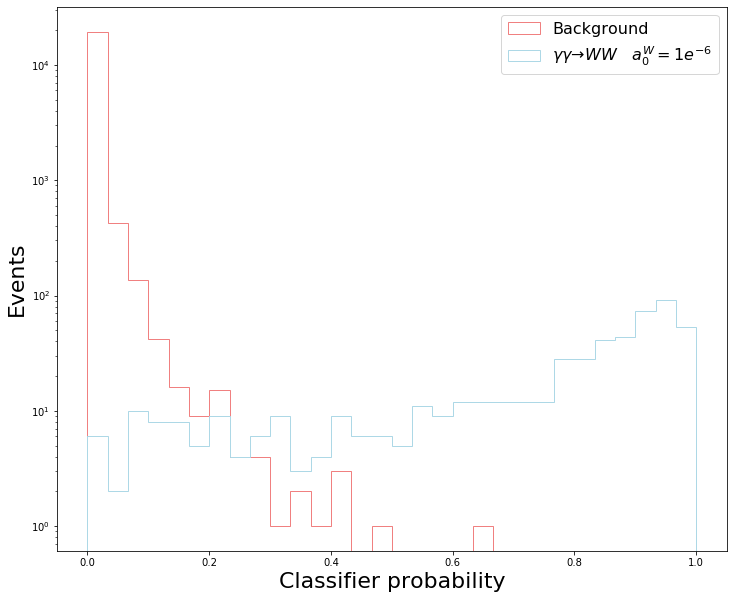

In [33]:
fig = plt.figure( figsize=(12,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='lightcoral', bins=30, range=(0.,1.), label="Background" )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='lightblue', bins=30, range=(0.,1.), label=r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$" )
plt.yscale('log')
plt.xlabel( "Classifier probability", fontsize=22 )
plt.ylabel( "Events", fontsize=22 )
plt.legend( loc='best', fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

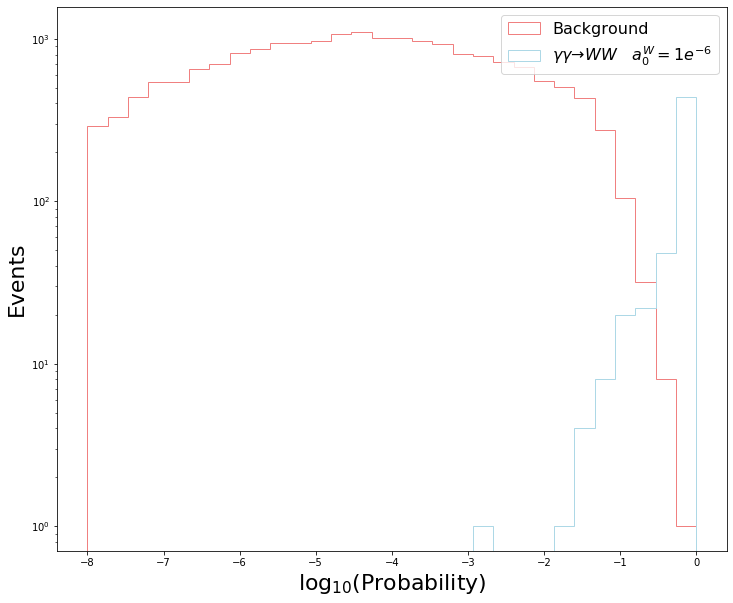

In [34]:
fig = plt.figure( figsize=(12,10) )
plt.hist( np.log10( y_test_proba[ y_test == 0 ] ), histtype='step', color='lightcoral', bins=30, range=(-8.,0.), label="Background" )
plt.hist( np.log10( y_test_proba[ y_test == 1 ] ), histtype='step', color='lightblue', bins=30, range=(-8.,0.), label=r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$" )
plt.yscale('log')
plt.xlabel( r"$\log_{10}(\rm{Probability})$", fontsize=22 )
plt.ylabel( "Events", fontsize=22 )
plt.legend( loc='best', fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_log_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_log_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

### ROC curve

[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00200080e-05
 5.00200080e-05 1.00040016e-04 1.00040016e-04 1.50060024e-04
 1.50060024e-04 2.50100040e-04 2.50100040e-04 3.00120048e-04
 3.00120048e-04 3.50140056e-04 3.50140056e-04 4.00160064e-04
 4.00160064e-04 4.50180072e-04 4.50180072e-04 5.00200080e-04
 5.00200080e-04 6.50260104e-04 6.50260104e-04 7.50300120e-04
 7.50300120e-04 8.50340136e-04 8.50340136e-04 1.00040016e-03
 1.00040016e-03 1.10044018e-03 1.10044018e-03 1.20048019e-03
 1.20048019e-03 1.25050020e-03 1.25050020e-03 1.40056022e-03
 1.40056022e-03 1.45058023e-03 1.45058023e-03 1.60064026e-03
 1.60064026e-03 1.65066026e-03 1.65066026e-03 1.75070028e-03
 1.75070028e-03 1.95078031e-03 1.95078031e-03 2.00080032e-03
 2.00080032e-03 2.05082033e-03 2.05082033e-03 2.35094038e-03
 2.35094038e-03 2.65106042e-03 2.65106042e-03 2.70108043e-03
 2.70108043e-03 2.85114046e-03 2.85114046e-03 2.95118047e-03
 2.95118047e-03 3.00120048e-03 3.00120048e-03 3.05122049e-03
 3.05122049e-03 3.201280

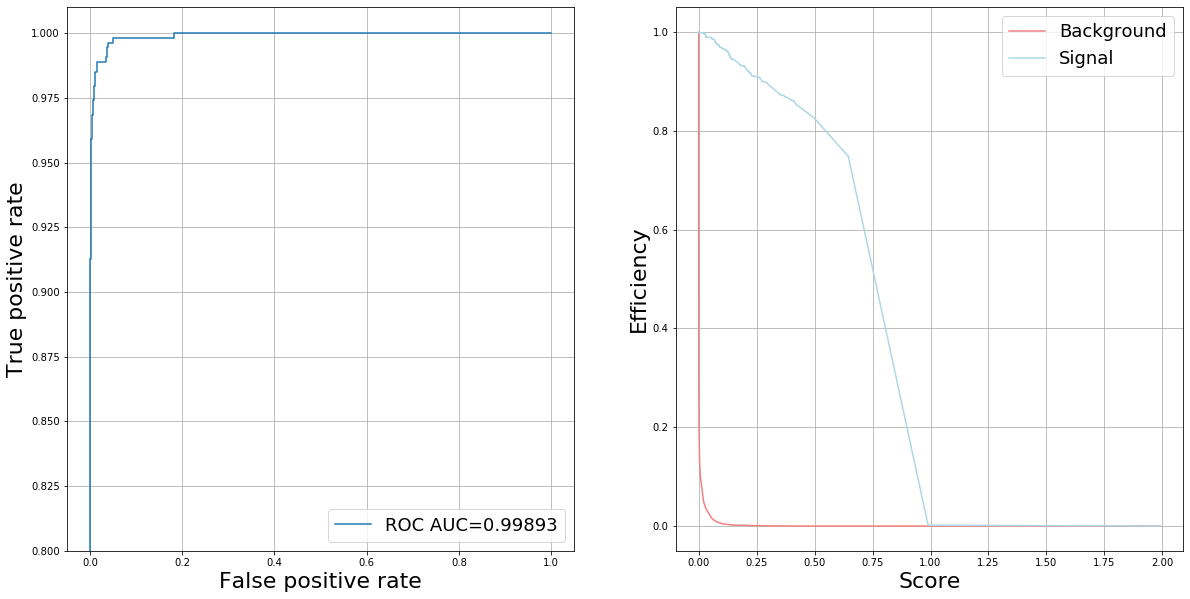

In [35]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve( y_test, y_test_proba )
auc = roc_auc_score(y_test, y_test_proba)

print ( fpr, tpr, thresholds )

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

axes[0].plot(fpr, tpr, label="ROC AUC={:.5f}".format(auc))
axes[0].legend( loc='best', fontsize=18 )
axes[0].set_xlabel( 'False positive rate', fontsize=22 )
axes[0].set_ylabel( 'True positive rate', fontsize=22 )
axes[0].set_ylim(0.80,1.01)
axes[0].grid()

#axes[0].plot(tpr,
#             np.divide(np.ones_like(fpr), fpr, out=np.zeros_like(fpr), where=fpr!=0), 
#             label="ROC AUC={:.5f}".format(auc))
#axes[0].legend(loc='best')
#axes[0].set_ylabel('Background rejection (1/false positive rate)')
#axes[0].set_xlabel('Signal efficiency (true positive rate)')
#axes[0].set_xlim(0.88,1.0)
#axes[0].grid()

axes[1].plot(thresholds,fpr,label='Background', color='lightcoral')
axes[1].plot(thresholds,tpr,label='Signal', color='lightblue')
axes[1].legend( loc='best', fontsize=18 )
axes[1].set_xlabel( 'Score', fontsize=22 )
axes[1].set_ylabel( 'Efficiency', fontsize=22 )
axes[1].grid()
#axes[1].set_xscale('log')
#axes[1].set_yscale('log')

if save_figures:
    plt.savefig( "plots/ANN-Keras_ROC_Efficiency_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_ROC_Efficiency_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

0.26366776
[0 1 0 ... 0 0 0]
0.9969314694851688
0.9072356215213359
0.9993497398959584
0.0006502601040415668
$\rm{Prob.} \geq 0.26 \;\rm{-}\; \rm{FPR} = 0.00065 \;\rm{-}\; \rm{TPR} = 0.9072$


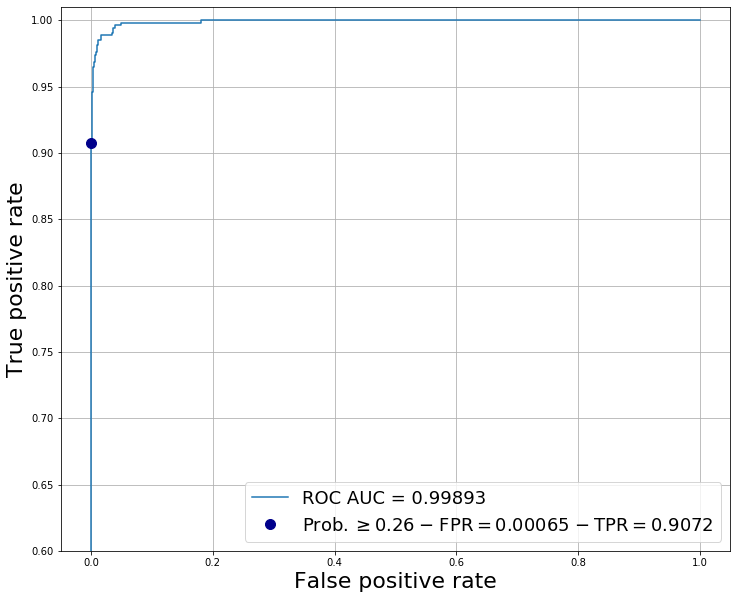

In [36]:
#prob_cut = 0.10

#tpr_target = 0.95
tpr_target = 0.90
#tpr_target = 0.85
#tpr_target = 0.70
prob_cut = thresholds[ np.argmax( tpr >= tpr_target ) ]
#fpr_target = 5.5e-04
#prob_cut = thresholds[ np.argmin( fpr <= fpr_target ) - 1 ]
print( prob_cut )

y_test_pred = ( y_test_proba >= prob_cut ).astype( "int32" )
y_test_pred = y_test_pred.ravel()
print ( y_test_pred )

from sklearn.metrics import accuracy_score
print ( accuracy_score( y_test, y_test_pred ) )
#tpr_cut = np.sum( ( y_test == 1 ) & ( y_test_pred == 1 ) ) / np.sum( ( y_test == 1 ) )
tpr_cut = accuracy_score( y_test[ y_test == 1 ], y_test_pred[ y_test == 1 ] )
print ( tpr_cut )
#tnr_cut = np.sum( ( y_test == 0 ) & ( y_test_pred == 0 ) ) / np.sum( ( y_test == 0 ) )
tnr_cut = accuracy_score( y_test[ y_test == 0 ], y_test_pred[ y_test == 0 ] )
print ( tnr_cut )
fpr_cut = ( 1. - tnr_cut )
print ( fpr_cut )

fig = plt.figure( figsize=(12,10) )
plt.plot(fpr, tpr, label="ROC AUC = {:.5f}".format(auc))
label_str = "$\\rm{{Prob.}} \geq {:.2f} \;\\rm{{-}}\; \\rm{{FPR}} = {:.5f} \;\\rm{{-}}\; \\rm{{TPR}} = {:.4f}$".format( prob_cut, fpr_cut, tpr_cut )
print ( label_str )
plt.plot( fpr_cut, tpr_cut, marker='o', markersize=10, linestyle='', color='darkblue',
          label=r"{}".format( label_str ) )
plt.legend( loc='best', fontsize=18 )
plt.xlabel( 'False positive rate', fontsize=22 )
plt.ylabel( 'True positive rate', fontsize=22 )
plt.ylim(0.60,1.01)
plt.grid()

if save_figures:
    plt.savefig( "plots/ANN-Keras_ROC_90pct_Point_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_ROC_90pct_Point_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

### Save model

In [37]:
if train_model and save_model:
    model_final.save( "model/keras_model.h5" )

### References

In [38]:
help( keras.models.Sequential )

Help on class Sequential in module tensorflow.python.keras.engine.sequential:

class Sequential(tensorflow.python.keras.engine.functional.Functional)
 |  Sequential(*args, **kwargs)
 |  
 |  `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
 |  
 |  `Sequential` provides training and inference features on this model.
 |  
 |  Examples:
 |  
 |  >>> # Optionally, the first layer can receive an `input_shape` argument:
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
 |  >>> # Afterwards, we do automatic shape inference:
 |  >>> model.add(tf.keras.layers.Dense(4))
 |  
 |  >>> # This is identical to the following:
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.Input(shape=(16,)))
 |  >>> model.add(tf.keras.layers.Dense(8))
 |  
 |  >>> # Note that you can also omit the `input_shape` argument.
 |  >>> # In that case the model doesn't have any weights until the first call
 |  >>> # to a training/evalua

In [39]:
help( keras.wrappers.scikit_learn.KerasClassifier )

Help on class KerasClassifier in module tensorflow.python.keras.wrappers.scikit_learn:

class KerasClassifier(BaseWrapper)
 |  KerasClassifier(build_fn=None, **sk_params)
 |  
 |  Implementation of the scikit-learn classifier API for Keras.
 |  
 |  Method resolution order:
 |      KerasClassifier
 |      BaseWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, x, y, **kwargs)
 |      Constructs a new model with `build_fn` & fit the model to `(x, y)`.
 |      
 |      Arguments:
 |          x : array-like, shape `(n_samples, n_features)`
 |              Training samples where `n_samples` is the number of samples
 |              and `n_features` is the number of features.
 |          y : array-like, shape `(n_samples,)` or `(n_samples, n_outputs)`
 |              True labels for `x`.
 |          **kwargs: dictionary arguments
 |              Legal arguments are the arguments of `Sequential.fit`
 |      
 |      Returns:
 |          history : object
 |       